# 1. prepare data

In [ ]:
import time
import pathlib
import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from google.colab import drive
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt
import glob

In [ ]:
drive.flush_and_unmount()
drive.mount('classification', force_remount=False)
!unzip 'classification/MyDrive/classification/dataset/images.zip' -d '/content/Assignment'

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: /content/Assignment/images/train/54/n02098413_21411.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2308.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2402.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_244.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2441.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2582.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2607.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2700.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2908.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_2974.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_3007.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_3033.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_3152.jpg  
  inflating: /content/Assignment/images/train/54/n02098413_3470

In [ ]:
# Defination of data, the image will be resized to 224*224*3, you can change resolution as you like
train_path = "/content/Assignment/images/train"
test_path = "/content/Assignment/images/test/"
img_width, img_height = 224, 224
channels = 3
batch_size = 64
num_images = 100
image_arr_size = img_width * img_height * channels

# 2. preprocessing

In [ ]:
# Data preprocessing: use the ImageDataGenerator
# Data augmentation has been proposed: rescale, shear, zoom, flip, rotation, shift 
# These augmentation can boost the classification quality
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    validation_split=0.2,

)

# The training and validation set will be split as 4:1
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

Found 9600 images belonging to 120 classes.
Found 2400 images belonging to 120 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)
nb_valid_samples = len(valid_generator.filenames)

# 3. CNN

## 3.1 First explore basic CNN model

In [ ]:
# Model 1: a 5 conv-layer model CNN
# Define the netwwork
model1 = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", strides=2, input_shape=[img_height, img_width, channels]), 
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 5, activation="relu", padding="same", strides=2),
    keras.layers.Conv2D(128, 5, activation="relu", padding="same", strides=2),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 5, activation="relu", padding="same", strides=1),
    keras.layers.Conv2D(256, 5, activation="relu", padding="same", strides=1),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(120, activation="softmax")
])
model1.summary() 

# Setting optimizer: SGD
model1.compile(optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9), 
                loss='categorical_crossentropy', metrics=['accuracy'])
epochs = 50
checkpoint_cb = keras.callbacks.ModelCheckpoint("model1.h5", save_best_only=True)
# Train the model
log = model1.fit_generator(
    train_generator,
    validation_data=valid_generator, 
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps= valid_generator.samples // batch_size,
    epochs=epochs, 
    callbacks=[checkpoint_cb], 
    verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       204928    
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         8

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
150/150 [==============================] - 171s 1s/step - loss: 4.7877 - accuracy: 0.0090 - val_loss: 4.7874 - val_accuracy: 0.0076
Epoch 2/50
150/150 [==============================] - 161s 1s/step - loss: 4.7875 - accuracy: 0.0083 - val_loss: 4.7872 - val_accuracy: 0.0106
Epoch 3/50
150/150 [==============================] - 160s 1s/step - loss: 4.7873 - accuracy: 0.0110 - val_loss: 4.7870 - val_accuracy: 0.0084
Epoch 4/50
150/150 [==============================] - 160s 1s/step - loss: 4.7871 - accuracy: 0.0119 - val_loss: 4.7868 - val_accuracy: 0.0114
Epoch 5/50
150/150 [==============================] - 163s 1s/step - loss: 4.7870 - accuracy: 0.0096 - val_loss: 4.7866 - val_accuracy: 0.0080
Epoch 6/50
150/150 [==============================] - 160s 1s/step - loss: 4.7868 - accuracy: 0.0098 - val_loss: 4.7865 - val_accuracy: 0.0097
Epoch 7/50
150/150 [==============================] - 158s 1s/step - loss: 4.7865 - accuracy: 0.0091 - val_loss: 4.7861 - val_accuracy: 0.0093

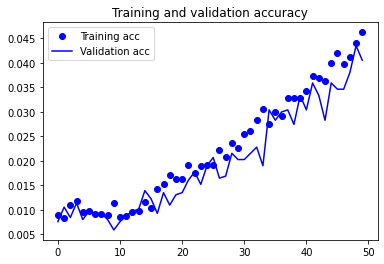

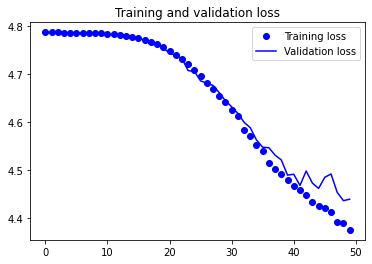

In [ ]:
# Show the result
%matplotlib inline
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(len(acc))
# Plot the training and validation acc and loss
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Decrease the batch size to avoid OOM
# Reload the data generation
epochs = 20
batch_size = 16
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
    validation_split=0.2,

)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='training',
    shuffle= True,
    seed= 1337
)

valid_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= 'categorical',
    subset='validation',
    shuffle= True,
    seed= 1337
)

Found 9600 images belonging to 120 classes.
Found 2400 images belonging to 120 classes.


In [ ]:
# Explore different models
# Load the pretrained xception with imagenet
model_xception=keras.applications.xception.Xception(include_top=False, weights='imagenet',
                                    input_tensor=None,  input_shape=[img_height, img_width, channels],
                                    pooling=None)
# The previous output is 1000 classes, so we need to modify the output layers
avg = keras.layers.GlobalAveragePooling2D()(model_xception.output)
# The output class is 120. Due to the multi-class problem, the loss is softmax.
output = keras.layers.Dense(120, activation="softmax")(avg)
xception = keras.Model(inputs=model_xception.input, outputs=output)
xception.summary()
xception.compile(optimizer=keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
                loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_xception.h5", save_best_only=True)
# Train the xception model
log = xception.fit_generator(
    train_generator,
    validation_data=valid_generator, 
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps= valid_generator.samples // batch_size,
    epochs=epochs, 
    callbacks=[checkpoint_cb], 
    verbose=1)

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
600/600 [==============================] - 169s 273ms/step - loss: 4.7889 - accuracy: 0.0128 - val_loss: 4.7366 - val_accuracy: 0.0250
Epoch 2/20
600/600 [==============================] - 163s 272ms/step - loss: 4.6856 - accuracy: 0.0330 - val_loss: 4.5971 - val_accuracy: 0.0542
Epoch 3/20
600/600 [==============================] - 163s 272ms/step - loss: 4.5259 - accuracy: 0.0958 - val_loss: 4.3758 - val_accuracy: 0.1546
Epoch 4/20
600/600 [==============================] - 163s 272ms/step - loss: 4.3128 - accuracy: 0.2079 - val_loss: 4.1165 - val_accuracy: 0.2917
Epoch 5/20
600/600 [==============================] - 163s 271ms/step - loss: 4.0551 - accuracy: 0.3293 - val_loss: 3.7981 - val_accuracy: 0.4075
Epoch 6/20
600/600 [==============================] - 163s 272ms/step - loss: 3.7689 - accuracy: 0.4219 - val_loss: 3.4541 - val_accuracy: 0.4754
Epoch 7/20
600/600 [==============================] - 163s 271ms/step - loss: 3.4659 - accuracy: 0.4907 - val_loss: 3.0940 -

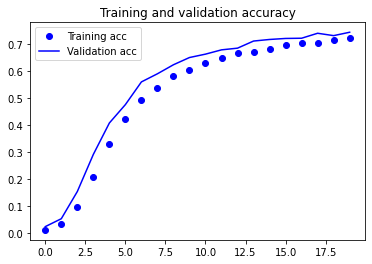

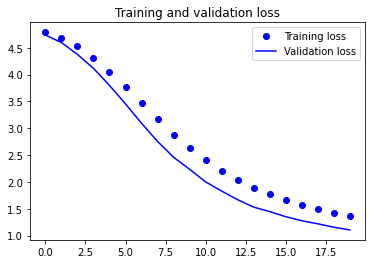

In [ ]:
# Show the results
%matplotlib inline
acc = log.history['accuracy']
val_acc = log.history['val_accuracy']
loss = log.history['loss']
val_loss = log.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()